## Corrective RAG (CRAG)

- **Document Relevance Grading**: LLM evaluates if retrieved documents can answer the question before generating a response

- **Query Rewriting**: Automatically rewrites irrelevant queries with better financial keywords and retries retrieval once

- **Single Retry Cycle**: Prevents infinite loops by allowing only one query rewrite and retrieval retry

- **Cited Answers**: Generates markdown-formatted responses with inline citations and structured references

https://arxiv.org/pdf/2401.15884.pdf

In [1]:
from typing_extensions import TypedDict, Annotated
from typing import Dict, List
import os

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_chroma import Chroma
from pydantic import BaseModel, Field

from scripts import my_tools

from dotenv import load_dotenv
load_dotenv()

[DB] Total documents in database: 1270


True

In [ ]:
# =============================================================================
# Configuration
# =============================================================================

LLM_MODEL = "qwen3"
BASE_URL = "http://localhost:11434"

llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL)

In [ ]:
# =============================================================================
# State
# =============================================================================

class AgentState(TypedDict):
    """State for Corrective RAG system."""
    messages: Annotated[List, add_messages]
    retrieved_docs: str
    is_relevant: bool
    rewritten_query: str


In [ ]:

# =============================================================================
# LangGraph Nodes
# =============================================================================

def retrieve_node(state: AgentState) -> Dict:
    """Retrieve documents based on user query."""
    print("\n[NODE] Retrieve - Fetching documents")

    # Get user question
    user_question = state["messages"][-1].content
    print(f"[QUERY] {user_question}")

    # Retrieve documents using my_tools
    result = my_tools.retrieve_docs.invoke({'query': user_question, 'k': 5})

    print(f"[RETRIEVED] Documents fetched")

    # Save for debugging
    os.makedirs("debug_logs", exist_ok=True)
    with open("debug_logs/crag_retrieved_docs.md", "w", encoding="utf-8") as f:
        f.write(f"Query: {user_question}\n\n")
        f.write(result)

    return {
        "retrieved_docs": result
    }

### Document Grading

In [ ]:
# =============================================================================
# Pydantic Schema for Structured Output
# =============================================================================

class GradeDecision(BaseModel):
    """Grade document relevance."""
    is_relevant: bool = Field(description="True if documents are relevant to answer the question, False if irrelevant")
    reasoning: str = Field(description="Brief explanation of why documents are relevant or not")


In [ ]:

def grade_node(state: AgentState) -> Dict:
    """Grade document relevance using LLM."""
    print("\n[NODE] Grade - Evaluating document relevance")

    # Create structured output LLM
    llm_structured = llm.with_structured_output(GradeDecision)

    user_question = state["messages"][-1].content
    retrieved_docs = state.get("retrieved_docs", "")

    # Truncate docs for grading (avoid overwhelming LLM)
    docs_preview = retrieved_docs[:2000] if len(retrieved_docs) > 2000 else retrieved_docs

    system_prompt = f"""You are a document relevance grader.

TASK: Evaluate if the retrieved documents are relevant to answer the user's question.

USER QUESTION: {user_question}

RETRIEVED DOCUMENTS (preview):
{docs_preview}

GRADING CRITERIA:
- is_relevant = True: If documents contain information that can answer the question
- is_relevant = False: If documents are completely irrelevant or off-topic

Output JSON:
{{
  "is_relevant": true/false,
  "reasoning": "Brief explanation..."
}}"""

    try:
        response = llm_structured.invoke([SystemMessage(content=system_prompt)])
        print(f"[GRADE] Relevant: {response.is_relevant}")
        print(f"[GRADE] Reasoning: {response.reasoning}")

        return {
            "is_relevant": response.is_relevant
        }
    except Exception as e:
        print(f"[ERROR] Grading failed: {e}")
        # Default to relevant to avoid breaking the flow
        return {
            "is_relevant": True
        }


In [ ]:

def rewrite_query_node(state: AgentState) -> Dict:
    """Rewrite query for better retrieval."""
    print("\n[NODE] Rewrite Query - Improving search query")

    user_question = state["messages"][-1].content

    system_prompt = f"""You are a query rewriting expert.

TASK: Rewrite the user's question to make it more specific and targeted for document retrieval.

ORIGINAL QUESTION: {user_question}

INSTRUCTIONS:
- Make the query more specific with keywords
- Add relevant financial terms (revenue, profit, earnings, etc.)
- Include company names, years, quarters if mentioned
- Keep it concise (one sentence)

Output ONLY the rewritten query, nothing else."""

    response = llm.invoke([SystemMessage(content=system_prompt)])
    rewritten = response.content.strip()

    print(f"[REWRITE] Original: {user_question}")
    print(f"[REWRITE] New: {rewritten}")

    return {
        "rewritten_query": rewritten
    }


In [ ]:
def retry_retrieve_node(state: AgentState) -> Dict:
    """Retry retrieval with rewritten query."""
    print("\n[NODE] Retry Retrieve - Fetching with rewritten query")

    rewritten_query = state.get("rewritten_query", "")
    print(f"[QUERY] {rewritten_query}")

    # Retrieve documents with rewritten query
    result = my_tools.retrieve_docs.invoke({'query': rewritten_query, 'k': 5})

    print(f"[RETRIEVED] Documents fetched with rewritten query")

    # Save for debugging
    with open("debug_logs/crag_retry_docs.md", "w", encoding="utf-8") as f:
        f.write(f"Rewritten Query: {rewritten_query}\n\n")
        f.write(result)

    return {
        "retrieved_docs": result
    }


In [ ]:
def answer_node(state: AgentState) -> Dict:
    """Generate final answer with citations."""
    print("\n[NODE] Answer - Generating final response")

    user_question = state["messages"][-1].content
    retrieved_docs = state.get("retrieved_docs", "")

    system_prompt = """You are an expert financial analyst.

TASK: Provide a detailed answer to the user's question using the retrieved documents.

REQUIREMENTS:
1. Write 200-300 words
2. Use MARKDOWN formatting:
   - ## Headings
   - **Bold** for key metrics
   - Bullet points for lists
   - Tables for comparisons
3. Include inline citations [1], [2], [3]
4. Add a References section at the end with format: "Company: x, Year: y, Quarter: z, Page: n"

Be thorough and detailed. Use all relevant information from the documents."""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Question: {user_question}\n\nRetrieved Documents:\n{retrieved_docs}\n\nProvide detailed answer with citations.")
    ]

    response = llm.invoke(messages)

    ai_message = AIMessage(content=response.content)

    return {
        "messages": [ai_message]
    }


In [ ]:
# =============================================================================
# Router Logic
# =============================================================================

def should_rewrite(state: AgentState) -> str:
    """Decide whether to rewrite query or proceed to answer."""
    is_relevant = state.get("is_relevant", True)

    if is_relevant:
        print("[ROUTER] Documents are relevant - proceeding to answer")
        return "answer"
    else:
        print("[ROUTER] Documents are irrelevant - rewriting query")
        return "rewrite"



[GRAPH] Building Corrective RAG workflow


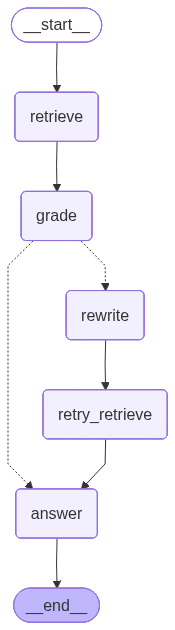

In [ ]:
# =============================================================================
# Build Graph
# =============================================================================

def create_crag():
    """Build Corrective RAG graph."""
    print("\n[GRAPH] Building Corrective RAG workflow")

    builder = StateGraph(AgentState)

    # Add nodes
    builder.add_node("retrieve", retrieve_node)
    builder.add_node("grade", grade_node)
    builder.add_node("rewrite", rewrite_query_node)
    builder.add_node("retry_retrieve", retry_retrieve_node)
    builder.add_node("answer", answer_node)

    # Define edges
    builder.add_edge(START, "retrieve")
    builder.add_edge("retrieve", "grade")
    builder.add_conditional_edges("grade", should_rewrite, ["rewrite", "answer"])
    builder.add_edge("rewrite", "retry_retrieve")  # Retry with rewritten query (no cycle!)
    builder.add_edge("retry_retrieve", "answer")  # Goes directly to answer
    builder.add_edge("answer", END)

    return builder.compile()

graph = create_crag()

graph

In [14]:
result = graph.invoke({
    "messages": [HumanMessage(content="What was Amazon's revenue in 2023?")]
})

result['messages'][-1].pretty_print()


[NODE] Retrieve - Fetching documents
[QUERY] What was Amazon's revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] What was Amazon's revenue in 2023?
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 3: score=29.6385
  [2] Doc 10: score=28.0907
  [3] Doc 2: score=27.3154
  [4] Doc 16: score=25.6818
  [5] Doc 4: score=25.5174
[RETRIEVED] 5 documents
[RETRIEVED] Documents fetched

[NODE] Grade - Evaluating document relevance
[GRADE] Relevant: False
[GRADE] Reasoning: The document discusses Amazon's segment structure, operating expense allocations, and business activities but does not mention specific revenue figures for 2023. The user's question requires total revenue data, which is absent from the provided content.
[ROUTER] Documents are irrelevant - rewriting query

[NODE] Rewrite Query - Improving search query
[REWRITE] Original: What was Amazon's revenue in 2023?
[REWRITE] New: What was Amazon's reported annual revenue in 2023?

[NODE] Retry Retrieve - Fetching with r

In [15]:
result = graph.invoke({
    "messages": [HumanMessage(content="Compare Apple and Google revenue in 2024 q1")]
})

result['messages'][-1].pretty_print()


[NODE] Retrieve - Fetching documents
[QUERY] Compare Apple and Google revenue in 2024 q1

[TOOL] retrieve_docs called
[QUERY] Compare Apple and Google revenue in 2024 q1
[BM25] Ranked 5 documents by heading+content chunks
  [1] Doc 1: score=25.2225
  [2] Doc 3: score=21.6813
  [3] Doc 0: score=21.6567
  [4] Doc 4: score=18.2055
  [5] Doc 2: score=17.6058
[RETRIEVED] 5 documents
[RETRIEVED] Documents fetched

[NODE] Grade - Evaluating document relevance
[GRADE] Relevant: False
[GRADE] Reasoning: The retrieved documents only contain Apple's financial data (segment operating income, expenses) for Q1 2024, but no revenue figures for Apple or Google. The documents do not provide the necessary information to compare Apple and Google's revenue.
[ROUTER] Documents are irrelevant - rewriting query

[NODE] Rewrite Query - Improving search query
[REWRITE] Original: Compare Apple and Google revenue in 2024 q1
[REWRITE] New: Compare the first-quarter 2024 revenue figures of Apple Inc. and Alphabet

In [16]:
result = graph.invoke({
    "messages": [HumanMessage(content="What is the capital of France?")]  # Irrelevant query to test rewrite
})

result['messages'][-1].pretty_print()


[NODE] Retrieve - Fetching documents
[QUERY] What is the capital of France?

[TOOL] retrieve_docs called
[QUERY] What is the capital of France?
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 0: score=47.8895
  [2] Doc 4: score=47.8895
  [3] Doc 2: score=44.9727
  [4] Doc 5: score=44.8283
  [5] Doc 9: score=44.7339
[RETRIEVED] 5 documents
[RETRIEVED] Documents fetched

[NODE] Grade - Evaluating document relevance
[GRADE] Relevant: False
[GRADE] Reasoning: The retrieved document contains financial information about Google's fiscal activities and corporate expenditures, but no information related to geography, countries, or capitals. It is completely unrelated to the question about France's capital.
[ROUTER] Documents are irrelevant - rewriting query

[NODE] Rewrite Query - Improving search query
[REWRITE] Original: What is the capital of France?
[REWRITE] New: What is the capital city of France and its role in the country's economic and political governance?

[NODE] Retr